# Load Data

**Data Link : https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set**

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report , ConfusionMatrixDisplay , confusion_matrix

In [3]:
classes = ['non-vehicles','vehicles']

In [4]:
# load data
data_dir = '/kaggle/input/vehicle-detection-image-set/data'
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  image_size=(256, 256),
  class_names = classes,
  seed=1,
  label_mode = 'categorical',
  batch_size=32)

val_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  class_names = classes,
  label_mode = 'categorical',
  image_size=(256, 256),
  batch_size=32)

Found 17760 files belonging to 2 classes.
Using 14208 files for training.
Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


/tmp/ipykernel_31/2869202749.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,2,j+1)


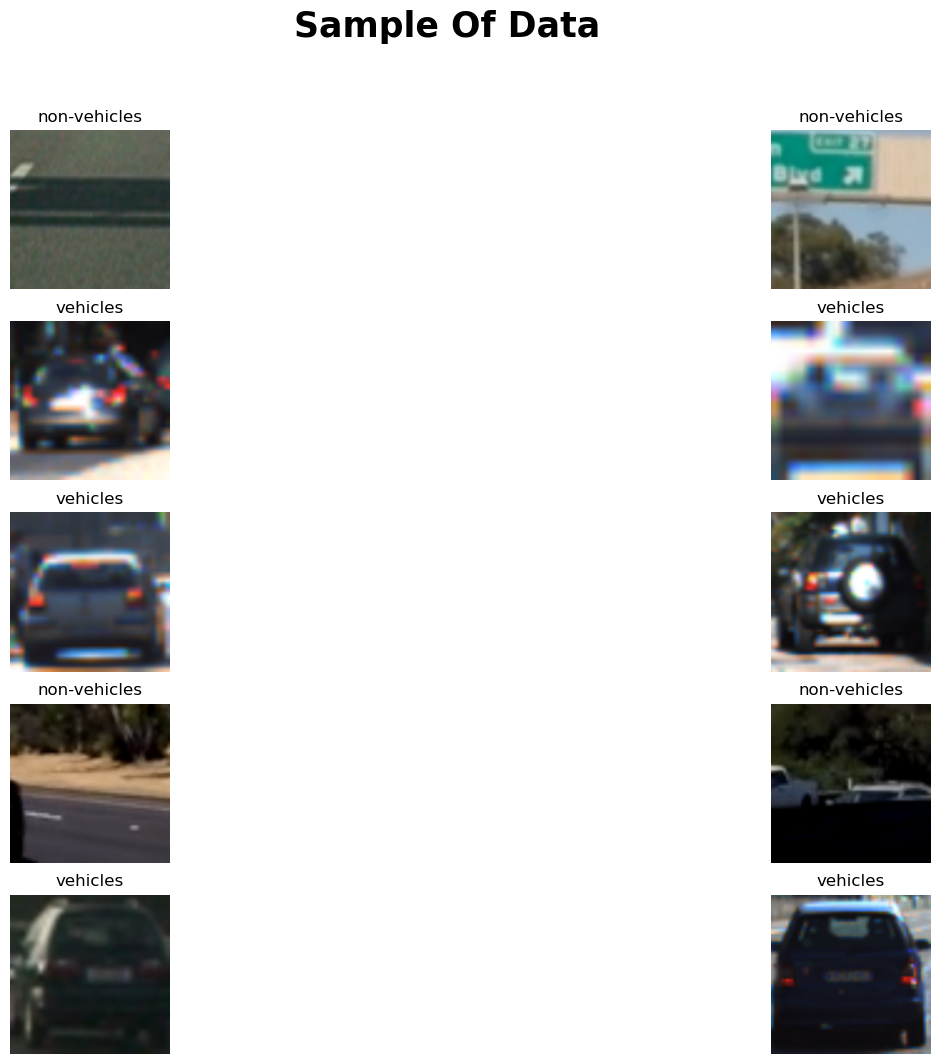

In [5]:
# visualize sample
n_images = 10
fig , axs = plt.subplots(figsize = (18,12))
fig.suptitle('Sample Of Data', fontweight = 'bold' , fontsize = 25 , ha = 'center')
for img , label in train_dataset.take(1):
  for j in range(n_images):
      plt.subplot(5,2,j+1)
      plt.title(classes[np.argmax(label[j])])
      plt.imshow(img[j]/255.0)
      plt.axis('off')

  break

# Image processing

In [ ]:
# train , test 
train_dataset , test_dataset = tf.keras.utils.split_dataset(
    train_dataset, left_size=0.9, shuffle = False
)

In [ ]:
# check For splitting
print(f'Training = {train_dataset.cardinality().numpy()}\nValidation = {val_dataset.cardinality().numpy()}\nTesting = {test_dataset.cardinality().numpy()}')

In [ ]:
# rescaling data
def rescaling(image , label):
  return image/255.0 , label

In [ ]:
# augment data
def augment_data(image, label):
   image = tf.image.random_flip_left_right(image)
   image = tf.image.random_flip_up_down(image)
   image = tf.image.random_hue(image , max_delta = 0.4)
   return image ,label

In [ ]:
train_dataset = train_dataset.map(rescaling).map(augment_data).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(rescaling).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(rescaling).prefetch(tf.data.AUTOTUNE)

In [ ]:
for img , label in test_dataset.take(1):

   plt.title(classes[np.argmax(label[10])])
   plt.imshow(img[10])
   plt.axis('off')

   break

# Modeling

In [ ]:
back_bone  = tf.keras.applications.InceptionV3(include_top = False , input_shape = (256,256,3))
back_bone.trainable = False

In [ ]:
Model = tf.keras.Sequential(
    (
        back_bone,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation = 'relu'),
        tf.keras.layers.Dense(128,activation = 'relu'),
        tf.keras.layers.Dense(len(classes),activation = 'softmax'),

    )
)
Model.summary()

In [ ]:
Model.compile(optimizer = 'adam' , loss = tf.keras.losses.BinaryCrossentropy() ,metrics = ['accuracy'] )

In [ ]:
Model.fit(train_dataset , validation_data = val_dataset , epochs = 10 , verbose = 1)

In [ ]:
Model.evaluate(test_dataset)

In [ ]:
y_pred = Model.predict(test_dataset)

In [ ]:
n_images = 30
fig,axs = plt.subplots(figsize = (10,35))
for img ,label in test_dataset.take(1):
   for j in range(n_images):
      plt.subplot(10,3,j+1)
      plt.title(f'Actual Label : {classes[np.argmax(label[j])]}\nPredicted Label : {classes[np.argmax(y_pred[j])]}')
      plt.imshow(img[j])
      plt.axis('off')
   break

In [ ]:
# determine true labels
y_true = []
for _ , label in test_dataset:
  for j in range(label.shape[0]):
    y_true.append(np.argmax(label[j]))


In [ ]:
# determine pred labels
y_pred_ = []
for i in range(y_pred.shape[0]):
  y_pred_.append(np.argmax(y_pred[i]))


                          precision    recall  f1-score   support         
                     0       0.51      0.51      0.51      1638         
                     1       0.48      0.48      0.48      1562    
              accuracy                           0.50      3200   
             macro avg       0.50      0.50      0.50      3200
          weighted avg       0.50      0.50      0.50      3200

In [ ]:
classification_report(y_true, y_pred_ )

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_true , y_pred_ ),display_labels = ['Non_Vehicle','Vehicle']).plot()